In [16]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import HTML
from matplotlib import animation

%matplotlib inline

In [47]:
gpe = 100         # gridpoints in eccentricity
gps = 80          # gridpoints in size

sMin = -4    
sMax = 8

eMin = 0.0    
eMax = 0.2

size = np.linspace(sMin,sMax,gps)
eccs = np.linspace(eMin,eMax,gpe)

# if all results have same strength law, it is convenient to fill it in here

A_stg = 5e7      # strength constant A in erg g^-1
B_stg = 3.3e-8    # strength constant B
s_small = 0            # size_0 of strength eq = 1 cm in log cm
alp_stg = -0.3    # strength constant alpha
bet_stg = 2       # strength constant beta

rho = 1
mass = np.log10(rho*1*np.pi/3) + 3*size  # log mass in g

asp_rat = (sMax-sMin)/(eMax-eMin)   # aspect ratio for plotting grid

G = 4*np.pi**2          # gravitational constant
sma = 45                # semimajor axis in au
h = 1                   # disk scale height h = 1 AU
mE = 5.972e27           # mass of Earth in g
vkep = np.sqrt(G/sma) * (1.5e11/3.15e7)     # keplerian velocity in m s^-1

def unpack(res, ge, gs):
    N = np.load('%s/N.npy' %res)
    N_i = np.load('%s/N_i.npy' %res)
    N_o = np.load('%s/N_o.npy' %res)
    ts = np.load('%s/ts.npy' %res)
    dt = np.load('%s/dt.npy' %res)
    fu = np.load('%s/fu.npy' %res)

    steps_track = len(N)
    steps_integ = len(dt)
    print(res, 'took', steps_integ,'steps')
        
    N = N.reshape(steps_track,ge,gs)
    N_i = N_i.reshape(steps_track,ge,gs)
    N_o = N_o.reshape(steps_track,ge,gs)

    Ndot = 10**N_i - 10**N_o

    return N, N_i, N_o, Ndot, ts, dt, fu

def qstar(s1, A = A_stg, B = B_stg, alp = alp_stg, bet = bet_stg, s0 = s_small):
    term1 = A * np.power(10,(s1-s0)*alp)
    term2 = B * rho * np.power(10,(s1-s0)*bet)
    return term1 + term2

def efault(s, A = A_stg, B = B_stg, alp = alp_stg, bet = bet_stg):
    Q_ = qstar(s,A,B,alp,bet)/10000
    efail = np.sqrt(2*Q_)/vkep
    return efail

def mass_underline(numbers, A=A_stg, B=B_stg, alp=alp_stg, bet=bet_stg, step='all'):
    """
    Calculate total mass under the cricical line, below which it cannot be quickly destroyed
    
    In: numbers -- ts-by-gpe-by-gps array; 3D array with numbers in each 2D bin at each timestep
        A, B, alp, bet -- floats; parameters of strength law used for this integration
        step -- 'all' or int; either all the timesteps or a particular one
        
    Out: mass_under -- float or array; total mass under the line at desired steps
    """
    efail = efault(size, A, B, alp, bet)  
    e_max = np.zeros(gps)
    mask = np.zeros((gpe,gps))
    
    # calculate max ecc bin at each size that is under this curve
    #   in our mask grid, set the cells under this one == 1
    
    cutoff = np.argmin(efail)
    for i in range(cutoff):
        e_max_it = np.argmin(abs(efail[i] - eccs))
        e_max[i] = e_max[i]
        
        mask[:e_max_it, i] = 1 
    
    if step == 'all':
        mass_under = np.zeros(len(numbers))
        for t in range(len(numbers)):
            num = 10**numbers[t]
            num_mask = num*mask
            mass_grid =  num_mask* 10**mass
            mass_under[t] = np.nansum(mass_grid)
            
    else:
        num = 10**numbers[step]
        num_mask = num*mask
        mass_grid =  num_mask* 10**mass
        mass_under = np.nansum(mass_grid)
            
    return mass_under

def opacity(numbers, step='all'):
    """
    calculate opacity at a certain step of an evolution of our numbers array
    
    In: numbers -- ts-by-gpe-by-gps array; 3D array with numbers in each 2D bin at each timestep
        step -- 'all' or int; either all the timesteps or a particular one
        
    Out: opacity -- float or array; opacity at selected timesteps
    """
    if step == 'all':
        opacity = np.zeros(len(numbers))
        for t in range(len(numbers)):
            for i, e in enumerate(eccs):
                N_sizes = 10**numbers[t,i]
                h = 2 * e * sma
                N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
                opacity[t] += np.nansum(N_scale)
    else:
        N_sizes = np.nansum(10**numbers[step],axis=0)
        N_scale = N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2)
        opacity = np.nansum(N_scale)
        
    return opacity

def get_massunder_opacity(resdir, gpe, gps):
    N, _, _, _, ts, _, _ = unpack(resdir, gpe, gps)
    mass_under = mass_underline(N)
    opac = opacity(N)
    return mass_under, opac, ts

def plot_massunder_opacity(resdirlist, labels, title=r'$m_0$ = 10 $M_\oplus$,  $e_0$ = 0.10', color=None,figure=None, axes=None, save=False):
    
    if figure == None:
        fig, ax = plt.subplots(2,figsize=(5,6),sharex=True,gridspec_kw={'height_ratios': [2, 1]})    
    else:
        fig = figure
        ax = axes
    
    if color == None:
        for i,direct in enumerate(resdirlist):
            mu, opac, ts = get_massunder_opacity(direct, gpe, gps)

            ax[0].plot(np.log10(ts), np.log10(mu/mE))
            ax[1].plot(np.log10(ts), np.log10(opac))
    else:
        for i,direct in enumerate(resdirlist):
            mu, opac, ts = get_massunder_opacity(direct, gpe, gps)

            alpha_val = (i + 1)/(len(resdirlist)+1)
            ax[0].plot(np.log10(ts), np.log10(mu/mE), c='darkorchid', alpha = alpha_val,lw=2.5)
            ax[1].plot(np.log10(ts), np.log10(opac), c=color, alpha = alpha_val)
                
    #ax[0].legend(labels, fontsize=13, loc='upper left',fancybox=False)
    ax[0].text(1.1,-4.65,labels[0],fontsize=13)
    ax[0].text(1.1,-9,labels[1],fontsize=13,rotation=26)
    ax[0].text(4.1,-9.8,labels[2],fontsize=13,rotation=71)
    ax[0].text(1.1,-6,labels[3],fontsize=13)
    ax[0].set_ylim(-10,-2)
    
    ax[0].set_ylabel(r'log $M_s$ [$M_\oplus$]',fontsize=15)
    #ax[0].set_title(title,fontsize=15)
    ax[0].set_yticks([-10,-8,-6,-4,-2])
    
    ax[1].hlines(0,-6,10,color='k',zorder=0)

    ax[1].set_xlim(1,np.log10(5e6))

    ax[1].set_ylabel(r'log $\kappa$',fontsize=16)
    ax[1].set_xlabel('log time [yr]',fontsize=16)

    for i in range(2):
        ax[i].tick_params('y',which='both',right=True,labelright=True, direction='in')
        ax[i].tick_params('x',which='both',direction='in',top=True)

    ax[1].set_yticks([-3,-2,-1,0,1])
    fig.tight_layout()
    
    if save == True:
        fig.savefig('mass_underline.png',dpi=300)
    
    return fig, ax

A_stg_5e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10 took 762 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:151: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(ts), np.log10(mu/mE), c='darkorchid', alpha = alpha_val,lw=2.5)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:152: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(ts), np.log10(opac), c=color, alpha = alpha_val)


A_stg_5e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10 took 7338 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:151: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(ts), np.log10(mu/mE), c='darkorchid', alpha = alpha_val,lw=2.5)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:152: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(ts), np.log10(opac), c=color, alpha = alpha_val)


A_stg_5e7/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10 took 2331 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:151: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(ts), np.log10(mu/mE), c='darkorchid', alpha = alpha_val,lw=2.5)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:152: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(ts), np.log10(opac), c=color, alpha = alpha_val)


flat_edist/results/e0-flat_t-5.0Myr_m0-10Me_p-100_r-10 took 2558 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:151: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(ts), np.log10(mu/mE), c='darkorchid', alpha = alpha_val,lw=2.5)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_10148/3641293441.py:152: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.log10(ts), np.log10(opac), c=color, alpha = alpha_val)


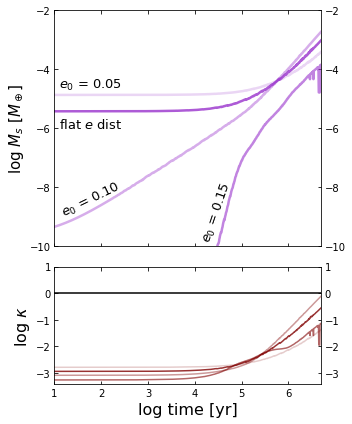

In [48]:
resdirlist1 = ['A_stg_5e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_5e7/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10',
               'flat_edist/results/e0-flat_t-5.0Myr_m0-10Me_p-100_r-10']

fig1, ax1 = plot_massunder_opacity(resdirlist1, 
                                   [r'$e_0$ = 0.05', r'$e_0$ = 0.10', r'$e_0$ = 0.15',r'flat $e$ dist'], 
                                   title=r'$m_0$ = 10 $M_\oplus$',
                                   color='maroon',
                                   save=False)

In [49]:
fig1.savefig('mass_underline_A5e7.png',dpi=300)

In [92]:
resdirlist2 = ['A_stg_1e8/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_1e8/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10']

fig2, ax2 = plot_massunder_opacity(resdirlist2, 
                                   [r'$e_0$ = 0.05', r'$e_0$ = 0.10', r'$e_0$ = 0.15'], 
                                   title=r'$m_0$ = 10 $M_\oplus$,  A = 5e7, 8e7',
                                   color='blue',
                                   figure=fig1,
                                   axes=ax1,
                                   save=False)

A_stg_1e8/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10 took 667 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/337415378.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


A_stg_1e8/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10 took 564 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/337415378.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


A_stg_1e8/results/e0-0.15_t-5.0Myr_m0-10Me_p-100_r-10 took 5939 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/337415378.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/337415378.py:117: RuntimeWarning: divide by zero encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


In [93]:
fig2.savefig('mass_underline_2stglaws.png',dpi=300)

In [94]:
resdirlist3 = ['A_stg_2e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10',
               'A_stg_2e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10']

fig3, ax3 = plot_massunder_opacity(resdirlist3, 
                                   [r'$e_0$ = 0.05', r'$e_0$ = 0.10', r'$e_0$ = 0.15'], 
                                   title=r'$m_0$ = 10 $M_\oplus$,  A = 2e7, 5e7, 8e7',
                                   color='C1',
                                   figure=fig2,
                                   axes=ax2,
                                   save=False)

A_stg_2e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10 took 1226 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/337415378.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


A_stg_2e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10 took 4633 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/337415378.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


In [95]:
fig3.savefig('mass_underline_3stglaws.png',dpi=300)

# Or, written out, 

In [22]:
resdir0 = 'A_stg_2e7/results/e0-0.01_t-100.0Myr_m0-10Me_p-100_r-10'
resdir1 = 'A_stg_2e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10'
resdir2 = 'A_stg_2e7/results/e0-0.08_t-5.0Myr_m0-10Me_p-100_r-10'
resdir3 = 'A_stg_2e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10'

mu_0, opac_0, ts_0 = get_massunder_opacity(resdir0, gpe, gps)
mu_1, opac_1, ts_1 = get_massunder_opacity(resdir1, gpe, gps)
mu_2, opac_2, ts_2 = get_massunder_opacity(resdir2, gpe, gps)
mu_3, opac_3, ts_3 = get_massunder_opacity(resdir3, gpe, gps)

A_stg_2e7/results/e0-0.01_t-100.0Myr_m0-10Me_p-100_r-10 took 29 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/2164868112.py:117: RuntimeWarning: divide by zero encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


A_stg_2e7/results/e0-0.05_t-5.0Myr_m0-10Me_p-100_r-10 took 1226 steps


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_50199/2164868112.py:117: RuntimeWarning: invalid value encountered in true_divide
  N_scale = (N_sizes*10**(size*2) / (2*sma*h*(1.496e13)**2))


A_stg_2e7/results/e0-0.08_t-5.0Myr_m0-10Me_p-100_r-10 took 7372 steps
A_stg_2e7/results/e0-0.10_t-5.0Myr_m0-10Me_p-100_r-10 took 4633 steps


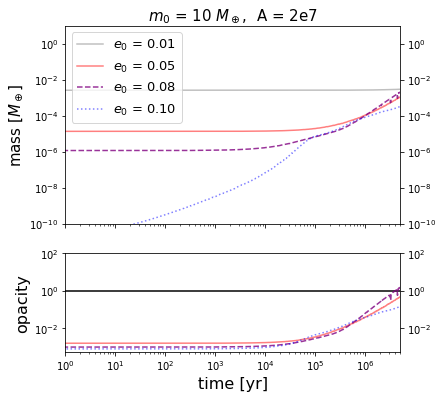

In [24]:
fig,ax = plt.subplots(2,figsize=(6,6),sharex=True,gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(ts_0,mu_0/mE, c='grey',alpha=.5)
ax[0].plot(ts_1,mu_1/mE, c='red',alpha=.5)
ax[0].plot(ts_2,mu_2/mE, c='purple', ls='--',alpha=.8)
ax[0].plot(ts_3,mu_3/mE, c='blue', ls=':',alpha=.5)

ax[0].set_ylim(1e-10,1e1)
ax[0].set_xlim(1,ts_3[-1])

ax[0].legend([r'$e_0$ = 0.01', r'$e_0$ = 0.05', r'$e_0$ = 0.08', r'$e_0$ = 0.10'], loc='upper left',fontsize=13)
ax[0].set_ylabel(r'mass [$M_\oplus$]',fontsize=15)
ax[0].set_title(r'$m_0$ = 10 $M_\oplus$,  A = 2e7',fontsize=15)
    
ax[1].plot(ts_0,opac_0, c='grey',alpha=.5)
ax[1].plot(ts_1,opac_1, c='red',alpha=.5)
ax[1].plot(ts_2,opac_2, c='purple', ls= '--',alpha=.8)
ax[1].plot(ts_3,opac_3, c='blue', ls=':',alpha=.5)

ax[1].hlines(1,1e-6,1e10,color='k',zorder=0)

ax[1].set_xlim(1,ts_3[-1])

ax[1].set_ylabel('opacity',fontsize=16)
ax[1].set_xlabel('time [yr]',fontsize=16)

for i in range(2):
    ax[i].tick_params('y',which='both',right=True,labelright=True)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

ax[1].set_yticks([.0001,.01,1,100])

plt.show()
fig.savefig('mass_underline_A2e7_evo.png',dpi=300)